In [1]:
!pwd

/home/jovyan/work


In [2]:
!wget https://github.com/xinyicoco/ISTM_6212/blob/master/Final%20Project/comparison_wrangle_script.png

--2016-12-08 23:29:34--  https://github.com/xinyicoco/ISTM_6212/blob/master/Final%20Project/comparison_wrangle_script.png
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2016-12-08 23:29:34 ERROR 404: Not Found.



from IPython.display import Image
PATH = "/home/jovyan/work/"

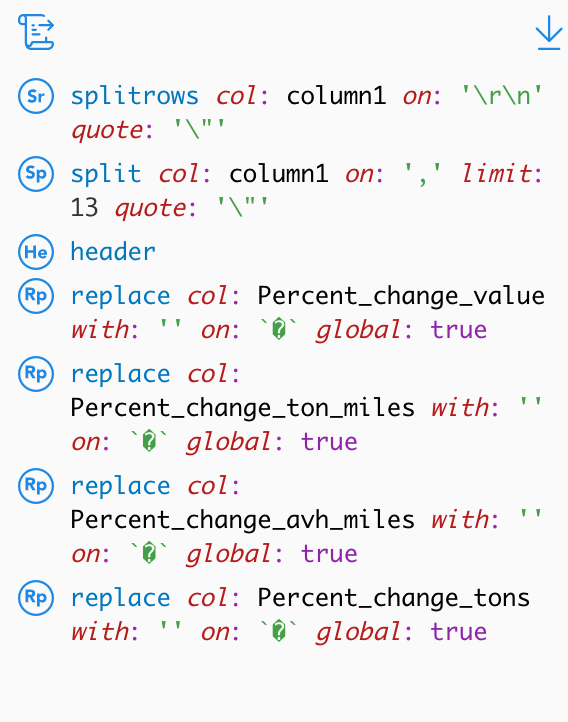

In [3]:
Image(filename = PATH + "comparison_wrangle_script.png", width = 400, height = 400)

In [4]:
!shuf NAICS_comparison_cleaned.csv | csvstat 

  1. 4244
	<class 'str'>
	Nulls: False
	Unique values: 45
	Max length: 10
  2. Grocery and related product merchant wholesalers 
	<class 'str'>
	Nulls: False
	Unique values: 45
	Max length: 71
  3. "647
	<class 'str'>
	Nulls: False
	Unique values: 43
	5 most frequent values:
		"1:	2
		"66:	2
		"99:	1
		periodical:	1
		appliance:	1
	Max length: 68
  4. 284"""
	<class 'str'>
	Nulls: False
	Unique values: 45
	Max length: 57
  5. "567
	<class 'str'>
	Nulls: False
	Unique values: 41
	5 most frequent values:
		"338:	2
		"216:	2
		"100:	2
		"120:	2
		"209:	1
	Max length: 28
  6. 732"""
	<class 'str'>
	Nulls: False
	Unique values: 44
	5 most frequent values:
		923""":	2
		317""":	1
		262""":	1
		279""":	1
		"49:	1
	Max length: 9
  7. 14
	<class 'str'>
	Nulls: False
	Unique values: 44
	5 most frequent values:
		10.1:	2
		464""":	1
		19.8:	1
		48.9:	1
		27.1:	1
	Max length: 9
  8. "336
	<class 'str'>
	Nulls: False
	Unique values: 44
	5 most frequent values:
		"36:	2
		"151:	1
		"211:	1
		"104:	1

After cleaned the data, we could see there is no NULL value

In [4]:
%load_ext sql

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [5]:
!echo 'redspot' | sudo -S service postgresql restart

[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.


In [6]:
%sql postgresql://dbuser@localhost:5432/projfinal

'Connected: dbuser@projfinal'

In [16]:
%%sql
DROP TABLE IF EXISTS NAICS_comparison;
CREATE TABLE NAICS_comparison (
    NAICS_code INTEGER,
    NAICS_title VARCHAR(100),
    Value_2012 VARCHAR(68),
    Value_2007 VARCHAR(57),
    Percent_change_value NUMERIC,
    Tons_2012 VARCHAR(50),
    Tons_2007 VARCHAR(50),
    Percent_change_tons NUMERIC,
    Ton_miles_2012 VARCHAR(14),
    Ton_miles_2007 VARCHAR(14),
    Percent_change_ton_miles NUMERIC,
    Average_miles_per_shipment_2012 VARCHAR(50),
    Average_miles_per_shipment_2007 NUMERIC,
    Percent_change_avh_miles VARCHAR(50)
);

Done.
Done.


[]

In [17]:
%%sql
COPY NAICS_comparison FROM '/home/jovyan/work/NAICS_comparison_cleaned.csv'
CSV
HEADER
DELIMITER ','; 

45 rows affected.


[]

In [18]:
%%sql
SELECT * FROM NAICS_comparison LIMIT 5;

5 rows affected.


naics_code,naics_title,value_2012,value_2007,percent_change_value,tons_2012,tons_2007,percent_change_tons,ton_miles_2012,ton_miles_2007,percent_change_ton_miles,average_miles_per_shipment_2012,average_miles_per_shipment_2007,percent_change_avh_miles
212,Mining (except oil and gas),"""99,888""","""85,730""",16.5,"""2,900,863""","""3,638,118""",20.3,"""859,267""","""1,057,505""",18.7,47,53,11.1
311,Food manufacturing,"""744,573""","""585,676""",27.1,"""545,892""","""568,950""",4.1,"""261,169""","""264,425""",1.2,239,305,21.6
312,Beverage and tobacco product manufacturing,"""142,936""","""129,804""",10.1,"""159,843""","""143,530""",11.4,"""49,408""","""42,063""",17.5,292,227,28.3
313,Textile mills,"""30,328""","""35,936""",15.6,"""7,101""","""8,989""",21,"""3,731""","""4,133""",9.7,765,811,5.6
314,Textile product mills,"""21,595""","""28,448""",24.1,"""5,096""","""7,022""",27.4,"""2,313""","""3,131""",26.1,918,854,7.6


In [19]:
%%sql
ALTER TABLE NAICS_comparison_cleaned
ADD PRIMARY KEY(NAICS_code)

Done.


[]

In [20]:
%%sql
ALTER TABLE industry_classification
ADD FOREIGN KEY (industry_id) REFERENCES NAICS_comparison_cleaned(NAICS_code);

Done.


[]

In [21]:
%%sql
ALTER TABLE shipment_dimension
ADD FOREIGN KEY (naics) REFERENCES NAICS_comparison_cleaned(NAICS_code);

Done.


[]

In [22]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import rc

In [45]:
%%sql
SELECT NAICS_code, NAICS_title, Value_2007, Value_2012, COUNT (shipmt_id) as count_2012
FROM industry_classification, cf_fact, NAICS_comparison_cleaned, shipment_dimension
WHERE cf_fact.shipment_key = shipment_dimension.shipment_key
AND shipment_dimension.naics = industry_classification.industry_id
AND industry_classification.industry_id = NAICS_comparison_cleaned.NAICS_code
GROUP BY industry_descr, naics_code
ORDER BY count_2012 DESC
;

45 rows affected.


naics_code,naics_title,value_2007,value_2012,count_2012
325,Chemical manufacturing,"""713,674""","""785,839""",48896
332,Fabricated metal product manufacturing,"""338,290""","""333,287""",46241
4238,"""Machinery, equipment, and supplies merchant wholesalers ""","""363,108""","""433,454""",43675
311,Food manufacturing,"""585,676""","""744,573""",40987
4244,Grocery and related product merchant wholesalers,"""567,732""","""647,284""",38865
326,Plastics and rubber products manufacturing,"""209,268""","""216,973""",33471
333,Machinery manufacturing,"""343,262""","""402,610""",32369
212,Mining (except oil and gas),"""85,730""","""99,888""",31112
323,Printing and related support activities,"""98,848""","""79,263""",30803
4236,Electrical and electronic goods merchant wholesalers,"""338,597""","""450,951""",30205


From the above analysis, we could have a direct look of the values of total shipments for both year 2007 and 2012. The top two industries are Chemical manufacturing and Fabricated metal product manufacturing. For each of the industry, it have 48896 and 46241 shipments relatively in 2012.

In [46]:
data = _.DataFrame()

In [47]:
data = data.as_matrix()

In [108]:
value07 = [int(string.replace(',','').strip('"')) for string in data[:,2]]

In [109]:
value12 = [int(string.replace(',','').strip('"')) for string in data[:,3]]

In [110]:
names = [name.strip('"').strip() for name in data[:,1]]

In [116]:
values = np.vstack((value07,value12))
values = values.transpose()

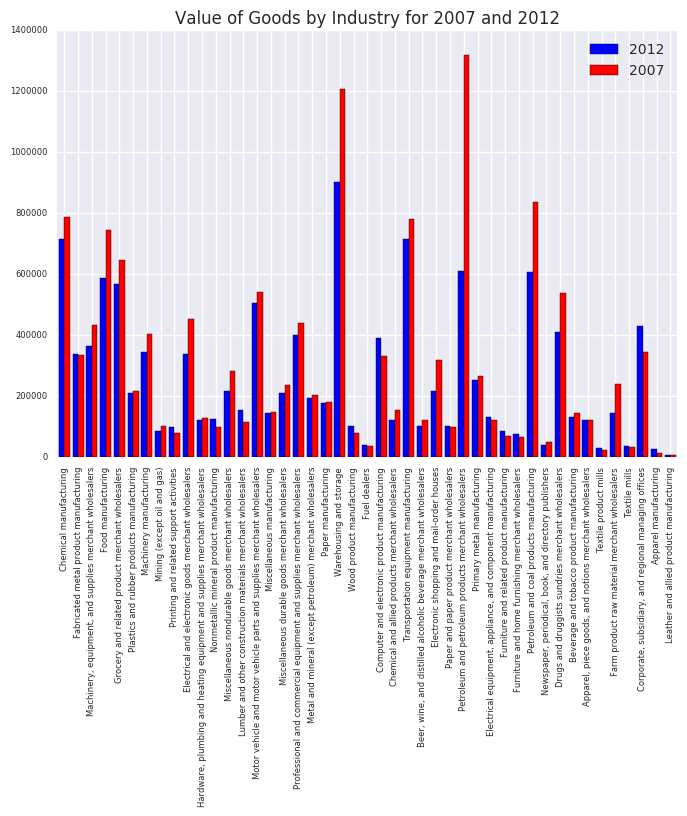

In [120]:
pos = np.arange(len(values))+0.5

ax = plt.subplot(111)
ax.bar(pos - 0.2, height = values[:,0], width = 0.4, align = 'center', color='blue',label='2012')
ax.bar(pos + 0.2, height = values[:,1], width = 0.4, align = 'center',color='red',label='2007')
ax.legend(loc=1)
ax.tick_params(labelsize = 6)
plt.xticks(pos, [industry for industry in names], rotation = 90)
plt.title('Value of Goods by Industry for 2007 and 2012')
plt.xlim([0,45])
plt.show()

In [49]:
%%sql
SELECT NAICS_code, NAICS_title, Percent_change_ton_miles, COUNT (shipmt_id) as count_2012
FROM industry_classification, cf_fact, NAICS_comparison_cleaned, shipment_dimension
WHERE cf_fact.shipment_key = shipment_dimension.shipment_key
AND shipment_dimension.naics = industry_classification.industry_id
AND industry_classification.industry_id = NAICS_comparison_cleaned.NAICS_code
GROUP BY industry_descr, naics_code
ORDER BY Percent_change_ton_miles DESC
LIMIT 20;

20 rows affected.


naics_code,naics_title,percent_change_ton_miles,count_2012
315,Apparel manufacturing,71.3,5228
45431,Fuel dealers,58.8,22200
551114,"""Corporate, subsidiary, and regional managing offices """,56.6,7141
4241,Paper and paper product merchant wholesalers,51,18330
4247,Petroleum and petroleum products merchant wholesalers,49.6,17461
4541,Electronic shopping and mail-order houses,46.8,18668
323,Printing and related support activities,35.4,30803
4234,Professional and commercial equipment and supplies merchant wholesalers,34.5,23756
4239,Miscellaneous durable goods merchant wholesalers,32.7,24095
4931,Warehousing and storage,30.5,22538


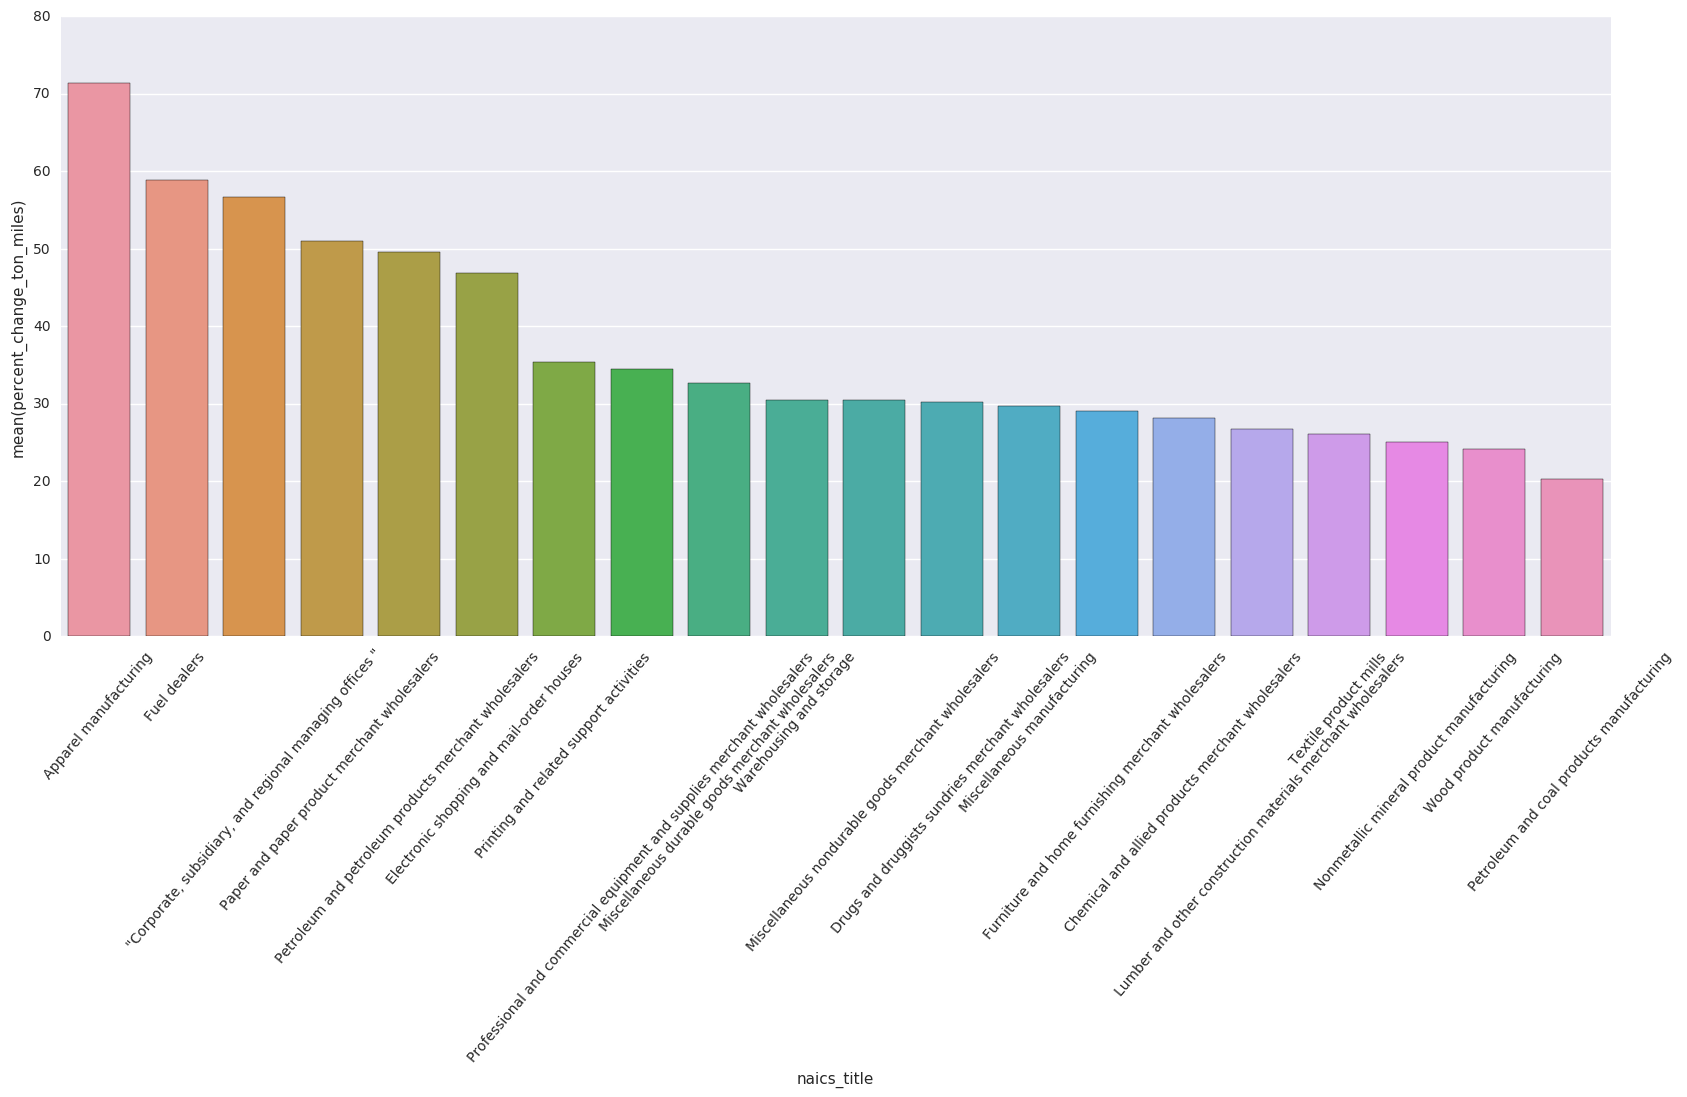

In [50]:
d = _.DataFrame()
rc('figure', figsize=(20, 8))
splt = sns.barplot(x='naics_title', y='percent_change_ton_miles', data=d)
labels = [l for l in splt.get_xmajorticklabels()]
splt.set_xticklabels(labels, rotation=50)

From the above plot, we can see that Apparel manufacturing and Fuel dealers industries have the most percentage change of ton-miles from 2007 to 2012.